In [374]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import tempfile
import pathlib
import shutil


In [381]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [337]:
train_data_path = "./challengeB_data/2022challengeB_train.csv"
test_data_path = "./challengeB_data/2022challengeB_test.csv"

train_df = pd.read_csv(train_data_path, index_col=[0])
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df_without_country = train_df.drop(["country"], axis=1)

test_df = pd.read_csv(test_data_path, index_col=[0])

train_df.head()

,country,crop_item,year,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,YIELD
0,Morocco,"Rice, paddy",2005,346.0,13966.00,18.18,68000
1,Lesotho,Wheat,1997,788.0,0.30,14.28,16291
2,Thailand,Maize,2008,1622.0,65423.00,27.48,40748
3,Saudi Arabia,Maize,2006,59.0,4046.34,26.42,58203
4,Burundi,Sweet potatoes,2001,1274.0,72.56,21.24,65072


In [130]:
train_df_without_country.head()

,crop_item,year,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,YIELD
0,Maize,2000,691.0,527.25,8.78,27011
1,Wheat,1994,1522.0,15373.00,6.70,35157
2,"Rice, paddy",2009,2280.0,9387.95,27.23,45355
3,Cassava,2007,1083.0,27422.77,25.46,322204
4,Sweet potatoes,1999,51.0,4823.00,22.28,240545


In [182]:
train_df_onehot = pd.get_dummies(train_df, columns=["country", "crop_item"], prefix=["Country", "Crop_Item"])
train_target = train_df_onehot.pop("YIELD")
train_features = train_df_onehot

In [143]:
country_features = [col for col in train_features.columns if "Country" in col]
train_features_without_country = train_features.drop(columns=country_features, axis=1)
train_features_without_country.shape

(25723, 14)

In [66]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score, RepeatedKFold

In [186]:
np.array(train_target).reshape(-1, 1).shape

(25723, 1)

In [188]:
scaler = MinMaxScaler()

scaled_train_features = scaler.fit_transform(train_features)
scaled_train_features_without_country = scaler.fit_transform(train_features_without_country)


In [146]:
def simplify_score(score):
    score = -score.mean()
    score = round(score)
    
    return score

In [55]:
def train_model(estimator, X, y):
    NUM_SPLITS = 10
    kfold = KFold(n_splits=NUM_SPLITS)
    
    score = cross_val_score(estimator, X, y, cv=kfold, scoring="neg_root_mean_squared_error", n_jobs=-1, verbose=1)
    
    score = simplify_score(score)
    
    print(f"RMSE of {estimator.__class__.__name__} after {NUM_SPLITS}-kfold cross_validation: {score}")

In [297]:
train_model(RandomForestRegressor(), scaled_train_features, train_target)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   33.2s remaining:   22.2s


RMSE of RandomForestRegressor after 10-kfold cross_validation: 37471625229297


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   47.1s finished


In [152]:
def compare_models(models, X, y, scoring):
    """Compares the performance of a variety of regression models, printing out as well as plotting the scores.
    Parameters: 
        models - dictionary
        X - 2d array
        y - 1d array
        scoring - The scoring metric, as defined by the sklearn
    """
    model_results = {}
    for name, model in zip(models.keys(), models.values()):
        # k-fold cross-validation with 3 repeats. I use a split of 8 because it perfectly divides the 512 samples.
        # Setting the random state to an int ensures that output is reproducible across multiple function calls, 
        # thus allowing the model to compare models fairly. 
        kfold = KFold(n_splits=10)
        print("Im supposed to be doing something")
        cv_results = cross_val_score(model, X, y, cv=kfold, n_jobs=-1, scoring=scoring, verbose=1)
        
        model_results[name] = simplify_score(cv_results)
        
        results = "{name}: {score}".format(name=name, score=simplify_score(cv_results))
        print(results)

    fig, ax = plt.subplots(figsize=(5, 5))
    fig.suptitle("Model Results Comparison", fontsize=20)
    x = list(models.keys())
    y = list(model_results.values())
    sns.barplot(x, y, ax=ax, palette=sns.color_palette("mako", len(models)))
    ax.set_xticklabels(model_results.keys())
    ax.set_xlabel("Models", fontsize=15)
    ax.set_ylabel("Average RMSE", fontsize=15)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10);

In [293]:
models = {}
models["RF"] = RandomForestRegressor()
models["LR"] = LinearRegression()
models["GB"] = GradientBoostingRegressor()
models["SVR"] = SVR()

X1 = scaled_train_features
X2 = scaled_train_features_without_country
y = scaled_target.ravel()

Im supposed to be doing something


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   48.3s remaining:   32.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RF: 91203
Im supposed to be doing something


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR: 83920
Im supposed to be doing something


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   21.8s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   28.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


GB: 83829
Im supposed to be doing something


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  2.0min remaining:  1.4min


SVR: 84428


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.8min finished
/Users/alexandrospouroullis/miniforge3/envs/LoopQPrize/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


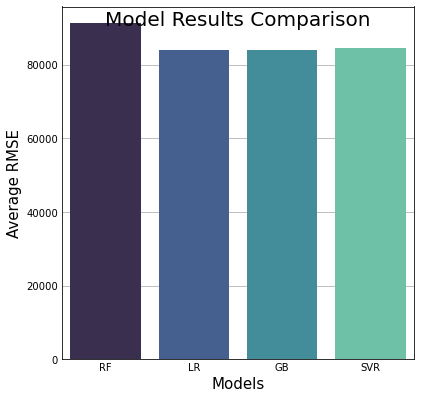

In [296]:
compare_models(models, X1, y, scoring="neg_root_mean_squared_error")

Im supposed to be doing something


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   10.2s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RF: 258
Im supposed to be doing something
LR: 4988
Im supposed to be doing something


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.6s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


GB: 2251
Im supposed to be doing something


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   13.2s remaining:    8.8s


SVR: 3508


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.6s finished
/Users/alexandrospouroullis/miniforge3/envs/LoopQPrize/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


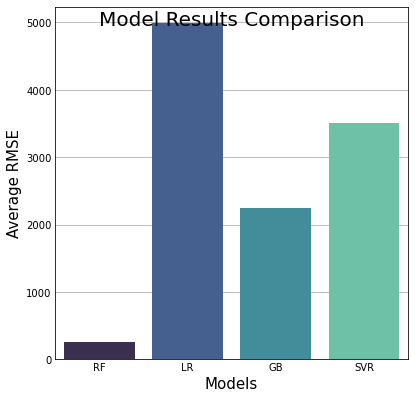

In [155]:
compare_models(models, X2, y, scoring="neg_root_mean_squared_error")

In [383]:
import tensorflow as tf
from tensorflow import keras
from keras import regularizers, layers

In [413]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /private/var/folders/p2/ptp4b_h53vbfb7zx0v3rs5q00000gn/T/pip-req-build-ol04xxre
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /private/var/folders/p2/ptp4b_h53vbfb7zx0v3rs5q00000gn/T/pip-req-build-ol04xxre
  Resolved https://github.com/tensorflow/docs to commit fb0365faf31342cd90e2bacfad54f3522877decb
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 KB 553.5 kB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=175828 sha256=5fe4909cb907e1250117a9b7a7d6d8d0a6dbba507dd4cec2e57db6924a5cb7c3
  Stored in directory: /private/var/folders/p2/ptp4b_h53vbfb7zx0v3rs5q00000gn/T/pip-ephem-wheel-cache-bfwj7f6e/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65f

In [598]:
rf = RandomForestRegressor()
score = cross_val_score(rf, scaled_train_features, train_target, n_jobs=-1, verbose=1, scoring="neg_root_mean_squared_error")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   38.6s remaining:   57.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.2s finished


In [604]:
rf.fit(scaled_train_features, train_target)
cross_val_score()

RandomForestRegressor()

In [613]:
from sklearn.neighbors import KNeighborsRegressor

In [626]:
def get_score(estimator):
    return cross_val_score(estimator, 
                           scaled_train_features, 
                           train_target,
                           verbose=1,
                           n_jobs=-1,
                           cv=10,
                           scoring="neg_root_mean_squared_error")

In [630]:
knn_manhattan = KNeighborsRegressor(p=1, n_jobs=-1)
knn_manhattan_score = get_score(knn_manhattan)
print(-knn_manhattan_score.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   17.0s remaining:   11.3s


8795.699443420852


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.3s finished


In [631]:
knn_euclidean = KNeighborsRegressor(n_jobs=-1)
knn_euclidean_score = get_score(knn_euclidean)
print(-knn_euclidean_score.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    8.9s remaining:    5.9s


9037.221921206334


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.4s finished


In [629]:
x_train, x_val, y_train, y_val  = train_test_split(scaled_train_features, train_target, test_size=0.2)

In [633]:
knn_manhattan = knn_manhattan.fit(x_train, y_train)
knn_euclidean = knn_euclidean.fit(x_train, y_train)

In [634]:
knn_manhattan_predictions = knn_manhattan.predict(x_val)
knn_euclidean_predictions = knn_euclidean.predict(x_val)


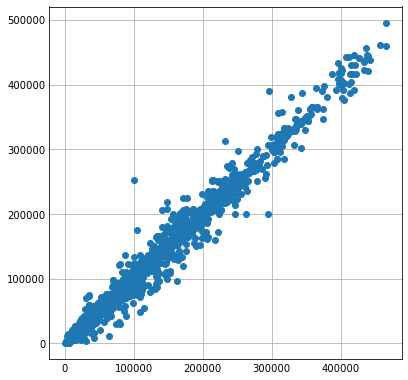

In [635]:
plt.scatter(knn_manhattan_predictions, y_val)

In [655]:
knn_manhattan_error = knn_manhattan_predictions - y_val

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 6.000e+00, 1.700e+01,
        3.800e+01, 7.900e+01, 3.370e+02, 4.208e+03, 3.230e+02, 5.300e+01,
        3.900e+01, 2.100e+01, 1.100e+01, 4.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00]),
 array([-152651.2  , -142795.704, -132940.208, -123084.712, -113229.216,
        -103373.72 ,  -93518.224,  -83662.728,  -73807.232,  -63951.736,
         -54096.24 ,  -44240.744,  -34385.248,  -24529.752,  -14674.256,
          -4818.76 ,    5036.736,   14892.232,   24747.728,   34603.224,
          44458.72 ,   54314.216,   64169.712,   74025.208,   83880.704,
          93736.2  ]),
 <BarContainer object of 25 artists>)

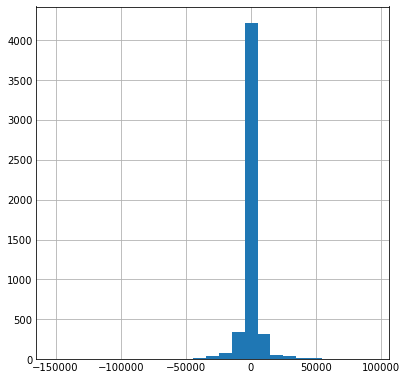

In [657]:
plt.hist(knn_manhattan_error, bins=25)

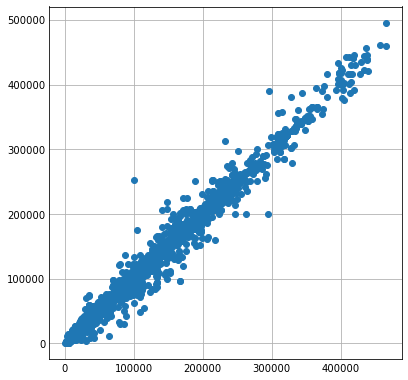

In [637]:
plt.scatter(knn_euclidean_predictions, y_val)

In [638]:
rf = RandomForestRegressor(n_jobs=-1)
rf_score = get_score(rf)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   32.3s remaining:   21.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   40.2s finished


In [640]:
rf = rf.fit(x_train, y_train)
rf_predictions = rf.predict(x_val)

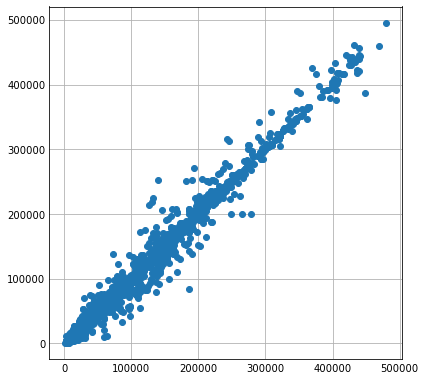

In [641]:
plt.scatter(rf_predictions, y_val)

In [682]:
mlp = MLPRegressor(hidden_layer_sizes=(128, 128),
                  verbose=1, 
                  max_iter=200,
                   learning_rate_init=0.1)


In [683]:
mlp_score = get_score(mlp)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  2.1min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.6min finished


In [687]:
mlp = mlp.fit(x_train, y_train)

Iteration 1, loss = 1885612542.76184630
Iteration 2, loss = 371316080.55691677
Iteration 3, loss = 252817657.91004586
Iteration 4, loss = 197512763.76124656
Iteration 5, loss = 166619491.84699768
Iteration 6, loss = 145981917.18497041
Iteration 7, loss = 133658486.65922318
Iteration 8, loss = 125854252.92313284
Iteration 9, loss = 116450368.44876976
Iteration 10, loss = 113025833.66769201
Iteration 11, loss = 109230196.28212461
Iteration 12, loss = 104344938.79218586
Iteration 13, loss = 103791041.35649419
Iteration 14, loss = 96678760.46242112
Iteration 15, loss = 95691433.21534802
Iteration 16, loss = 92774990.95029508
Iteration 17, loss = 91332183.59350152
Iteration 18, loss = 89525866.00679611
Iteration 19, loss = 89161052.15328109
Iteration 20, loss = 87296176.79788643
Iteration 21, loss = 84103202.47399744
Iteration 22, loss = 83453999.73883092
Iteration 23, loss = 87338698.03067379
Iteration 24, loss = 85097324.53943083
Iteration 25, loss = 81301759.51891337
Iteration 26, loss =

In [688]:
print("R2 scores for models")
print("-"*30)
print("Random Forest:", rf.score(x_val, y_val))
print("KNN-Manhattan:", knn_manhattan.score(x_val, y_val))
print("KNN-Euclidean:", knn_euclidean.score(x_val, y_val))
print("MLP:", mlp.score(x_val, y_val))

R2 scores for models
------------------------------
Random Forest: 0.9897238545331005
KNN-Manhattan: 0.989526115585853
KNN-Euclidean: 0.9890092834812829
MLP: 0.9880716165086846


In [651]:
rf_error = rf_predictions - y_val

In [652]:
np.max(rf_error)

101144.87

In [773]:
knn_minkowski = KNeighborsRegressor(p=1000)

In [774]:
knn_minkowski_score = cross_val_score(knn_minkowski, 
                                      scaled_train_features,
                                      train_target,
                                     verbose=1,
                                     cv=10,
                                     n_jobs=-1,
                                      scoring="neg_root_mean_squared_error",
                                     )
print(-knn_minkowski_score.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.3min remaining:   52.5s


13802.02351246698


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.9min finished


In [689]:
knn_manhattan = knn_manhattan.fit(x_train, y_train)

In [690]:
knn_manhattan_predictions = knn_manhattan.predict(x_val)

In [691]:
knn_manhattan_error = knn_manhattan_predictions - y_val

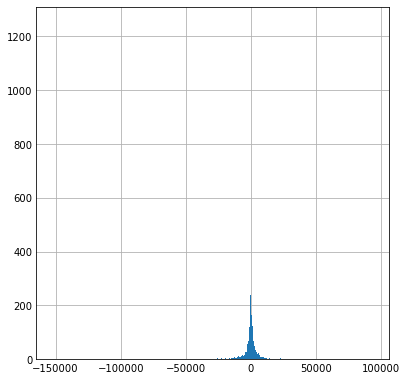

In [693]:
plt.hist(knn_manhattan_error, bins=1000);

{'whiskers': [<matplotlib.lines.Line2D at 0x304c293d0>,
 'caps': [<matplotlib.lines.Line2D at 0x304c29880>,
 'boxes': [<matplotlib.lines.Line2D at 0x304c291c0>],
 'medians': [<matplotlib.lines.Line2D at 0x304c29d60>],
 'fliers': [<matplotlib.lines.Line2D at 0x2ff070190>],
 'means': []}

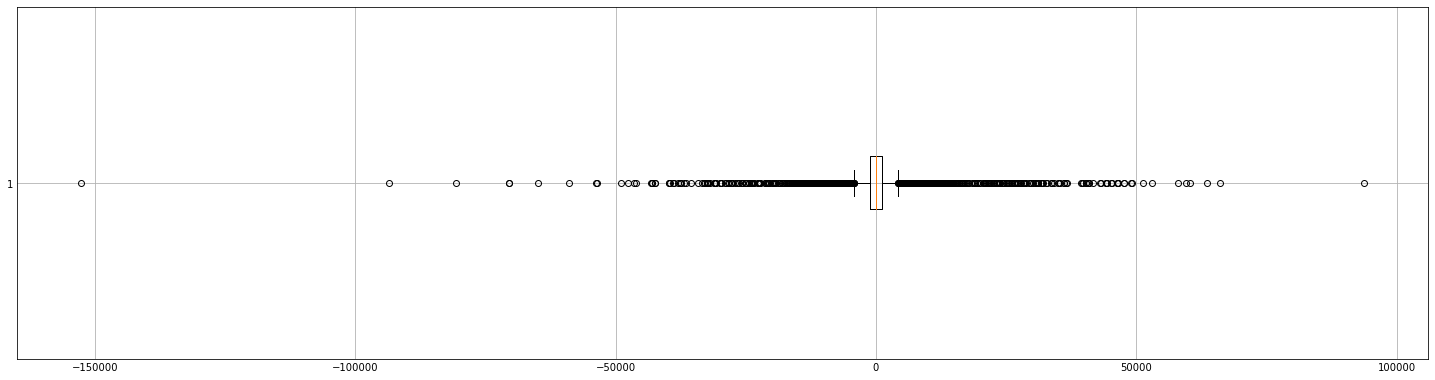

In [701]:
plt.figure(figsize=(20, 5))
plt.boxplot(knn_manhattan_error, vert=False)

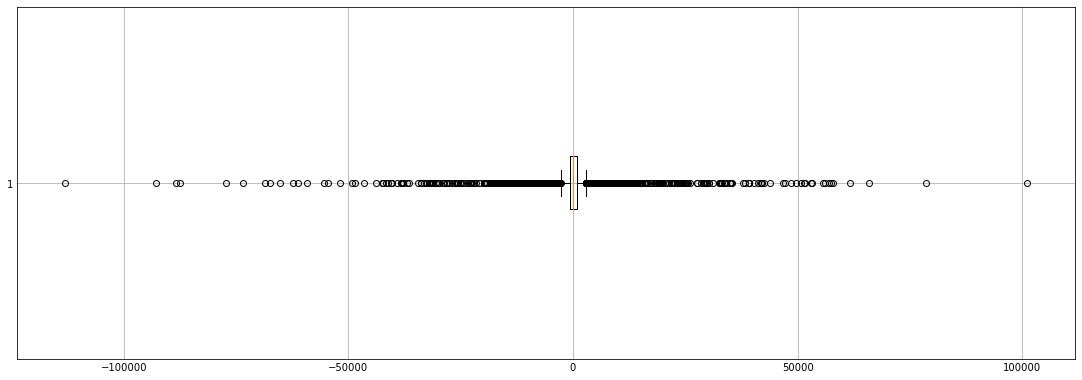

In [702]:
plt.figure(figsize=(15, 5))
boxplot_dict = plt.boxplot(rf_error, vert=False)

In [711]:
q3, q1 = np.percentile(rf_error, [75, 25])
iqr = q3 - q1

In [755]:
knn_mae_score = cross_val_score(knn_euclidean, scaled_train_features, 
                                train_target, 
                                scoring="neg_mean_absolute_error",
                                cv=10,
                                n_jobs=-1,
                                verbose=1
                               )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    8.5s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.6s finished


In [756]:
-knn_mae_score.mean()

3855.0231253433944

In [759]:
rf_mae_score = cross_val_score(rf,
                              scaled_train_features, 
                               train_target,
                              n_jobs=-1,
                              verbose=1,
                               scoring="neg_mean_absolute_error",
                              cv=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   44.1s remaining:   29.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   57.0s finished


In [760]:
-rf_mae_score.mean()

3177.8248460559744

In [ ]:
rf_mae_score = cross_val_score(scaled_train_features, )

In [ ]:
rf_error.any()

In [742]:
outliers_mask = (rf_error > q3 + iqr * 1.5) | (rf_error < q1 - 1.5 * iqr)

In [743]:
outliers = rf_error[outliers_mask]

In [744]:
outliers.shape

(1246,)

In [745]:
(outliers.shape[0]*1.0)/rf_error.shape[0]*100

24.217687074829932

In [712]:
iqr

1432.5200000000004

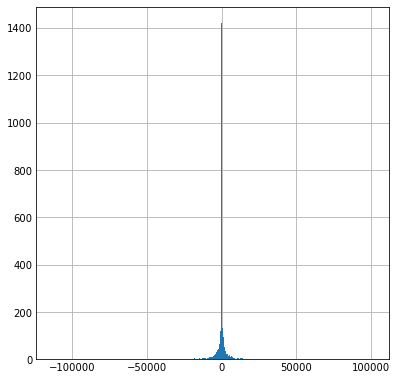

In [678]:

bin_counts, lower_bounds, bars = plt.hist(rf_error, bins=1000)

In [679]:
for bin_count, lower_bound in zip(bin_counts, lower_bounds):
    print(bin_count, lower_bound)

1.0 -113071.38
0.0 -112857.16375
0.0 -112642.94750000001
0.0 -112428.73125000001
0.0 -112214.515
0.0 -112000.29875
0.0 -111786.0825
0.0 -111571.86625
0.0 -111357.65000000001
0.0 -111143.43375000001
0.0 -110929.2175
0.0 -110715.00125
0.0 -110500.785
0.0 -110286.56875
0.0 -110072.35250000001
0.0 -109858.13625000001
0.0 -109643.92
0.0 -109429.70375
0.0 -109215.4875
0.0 -109001.27125
0.0 -108787.05500000001
0.0 -108572.83875000001
0.0 -108358.6225
0.0 -108144.40625
0.0 -107930.19
0.0 -107715.97375
0.0 -107501.7575
0.0 -107287.54125000001
0.0 -107073.32500000001
0.0 -106859.10875
0.0 -106644.8925
0.0 -106430.67625
0.0 -106216.46
0.0 -106002.24375000001
0.0 -105788.02750000001
0.0 -105573.81125
0.0 -105359.595
0.0 -105145.37875
0.0 -104931.1625
0.0 -104716.94625000001
0.0 -104502.73000000001
0.0 -104288.51375
0.0 -104074.2975
0.0 -103860.08125
0.0 -103645.865
0.0 -103431.64875000001
0.0 -103217.43250000001
0.0 -103003.21625
0.0 -102789.0
0.0 -102574.78375
0.0 -102360.5675
0.0 -102146.35125
0

In [788]:
len(scaled_train_features
)

25723

In [787]:
mlp = MLPRegressor(hidden_layer_sizes=(128),
                   learning_rate_init=0.1,
                   alpha=0,
                   batch_size=len(scaled_train_features))

score = cross_val_score(mlp, scaled_train_features, train_target, cv=5, scoring="neg_root_mean_squared_error",
                    n_jobs=-1, verbose=1)

print(-score.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   33.6s remaining:   50.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.8s finished


83962.82184540815


In [619]:
arr1 = np.array([1, 2, 3])
arr2 = np.array([4, 5, 6])
arr1 - arr2

array([-3, -3, -3])

In [ ]:
cross_val_score()

In [617]:
knn = KNeighborsRegressor()
score = cross_val_score(knn, scaled_train_features, train_target, n_jobs=-1, scoring="neg_root_mean_squared_error", verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished


In [618]:
-score.mean()

9331.316246116281

In [ ]:
MLPRegressor()

In [413]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /private/var/folders/p2/ptp4b_h53vbfb7zx0v3rs5q00000gn/T/pip-req-build-ol04xxre
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /private/var/folders/p2/ptp4b_h53vbfb7zx0v3rs5q00000gn/T/pip-req-build-ol04xxre
  Resolved https://github.com/tensorflow/docs to commit fb0365faf31342cd90e2bacfad54f3522877decb
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 KB 553.5 kB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=175828 sha256=5fe4909cb907e1250117a9b7a7d6d8d0a6dbba507dd4cec2e57db6924a5cb7c3
  Stored in directory: /private/var/folders/p2/ptp4b_h53vbfb7zx0v3rs5q00000gn/T/pip-ephem-wheel-cache-bfwj7f6e/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65f

In [208]:
avg_temp = np.array(train_features["avg_temp"])

avg_temp_normalizer = layers.Normalization(input_shape=[1, ], axis=None)
avg_temp_normalizer.adapt(avg_temp)

In [209]:
avg_temp_model = keras.Sequential([
    avg_temp_normalizer,
    layers.Dense(units=1)
])

avg_temp_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [210]:
avg_temp_model.predict(avg_temp[:10])

array([[-1.8008854 ],
       [ 0.23644343],
       [ 0.6248366 ],
       [-0.48659167],
       [ 1.1970226 ],
       [-0.15021554],
       [ 0.7635483 ],
       [-1.0119623 ],
       [ 1.2004905 ],
       [ 0.6248366 ]], dtype=float32)

In [215]:
avg_temp_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.1),
    loss="mean_squared_error",
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [216]:
history = avg_temp_model.fit(
    train_features["avg_temp"],
    target,
    epochs=100,
    verbose=1,
    validation_split=0.2
)

Epoch 1/100
644/644 [==============================] - 4s 6ms/step - loss: 12707291136.0000 - root_mean_squared_error: 112726.6250 - val_loss: 12781123584.0000 - val_root_mean_squared_error: 113053.6406
Epoch 2/100
644/644 [==============================] - 4s 6ms/step - loss: 12697208832.0000 - root_mean_squared_error: 112681.8984 - val_loss: 12771112960.0000 - val_root_mean_squared_error: 113009.3594
Epoch 3/100
644/644 [==============================] - 4s 6ms/step - loss: 12687098880.0000 - root_mean_squared_error: 112637.0312 - val_loss: 12761112576.0000 - val_root_mean_squared_error: 112965.0938
Epoch 4/100
644/644 [==============================] - 4s 6ms/step - loss: 12676987904.0000 - root_mean_squared_error: 112592.1406 - val_loss: 12751113216.0000 - val_root_mean_squared_error: 112920.8359
Epoch 5/100
644/644 [==============================] - 4s 6ms/step - loss: 12666883072.0000 - root_mean_squared_error: 112547.2500 - val_loss: 12741125120.0000 - val_root_mean_squared_erro

644/644 [==============================] - 3s 5ms/step - loss: 12311846912.0000 - root_mean_squared_error: 110958.7656 - val_loss: 12389581824.0000 - val_root_mean_squared_error: 111308.5000
Epoch 42/100
644/644 [==============================] - 4s 6ms/step - loss: 12302198784.0000 - root_mean_squared_error: 110915.2812 - val_loss: 12379995136.0000 - val_root_mean_squared_error: 111265.4375
Epoch 43/100
644/644 [==============================] - 4s 6ms/step - loss: 12292532224.0000 - root_mean_squared_error: 110871.6953 - val_loss: 12370404352.0000 - val_root_mean_squared_error: 111222.3281
Epoch 44/100
644/644 [==============================] - 3s 5ms/step - loss: 12282878976.0000 - root_mean_squared_error: 110828.1562 - val_loss: 12360844288.0000 - val_root_mean_squared_error: 111179.3438
Epoch 45/100
644/644 [==============================] - 4s 6ms/step - loss: 12273218560.0000 - root_mean_squared_error: 110784.5547 - val_loss: 12351277056.0000 - val_root_mean_squared_error: 11113

644/644 [==============================] - 4s 6ms/step - loss: 11933056000.0000 - root_mean_squared_error: 109238.5312 - val_loss: 12014013440.0000 - val_root_mean_squared_error: 109608.4609
Epoch 82/100
644/644 [==============================] - 4s 6ms/step - loss: 11923791872.0000 - root_mean_squared_error: 109196.1172 - val_loss: 12004830208.0000 - val_root_mean_squared_error: 109566.5625
Epoch 83/100
644/644 [==============================] - 4s 6ms/step - loss: 11914528768.0000 - root_mean_squared_error: 109153.7031 - val_loss: 11995620352.0000 - val_root_mean_squared_error: 109524.5156
Epoch 84/100
644/644 [==============================] - 4s 6ms/step - loss: 11905301504.0000 - root_mean_squared_error: 109111.4141 - val_loss: 11986492416.0000 - val_root_mean_squared_error: 109482.8438
Epoch 85/100
644/644 [==============================] - 4s 6ms/step - loss: 11896104960.0000 - root_mean_squared_error: 109069.2734 - val_loss: 11977355264.0000 - val_root_mean_squared_error: 10944

In [219]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error,epoch
95,1.179529e+10,108606.125000,1.187729e+10,108982.992188,95
96,1.178620e+10,108564.273438,1.186826e+10,108941.531250,96
97,1.177708e+10,108522.242188,1.185921e+10,108900.000000,97
98,1.176800e+10,108480.429688,1.185020e+10,108858.625000,98
99,1.175892e+10,108438.562500,1.184117e+10,108817.125000,99


In [227]:
np.max(history.history["val_root_mean_squared_error"])

113053.640625

In [335]:
def plot_loss(history):
    plt.rcParams["figure.figsize"] = (5, 5)
    plt.plot(history.history["root_mean_squared_error"], label="rmse")
    plt.plot(history.history["val_root_mean_squared_error"], label="val_rmse")
    max_val_rmse = np.max(history.history["val_root_mean_squared_error"])
    max_train_rmse = np.max(history.history["root_mean_squared_error"])
    max_rmse = max(max_train_rmse, max_val_rmse)
    plt.ylim([0, max_rmse])
    plt.xlabel("Epoch")
    plt.ylabel("RMSE (Avg. Temp.)")
    plt.legend()
    plt.show()

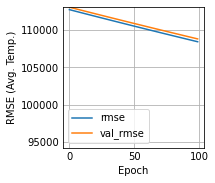

In [234]:
plot_loss(history)

In [ ]:
keras.optimizers.Adam()

In [266]:
def plot_avg_temp(x, y):
    plt.rcParams["figure.figsize"] = (15, 15)
    plt.scatter(train_features["avg_temp"], train_target, label="Data", alpha=0.1)
    plt.plot(x, y, label="Predictions", color="red")
    plt.xlabel("Avg. Temp.")
    plt.ylabel("Crop Yields")
    plt.legend()

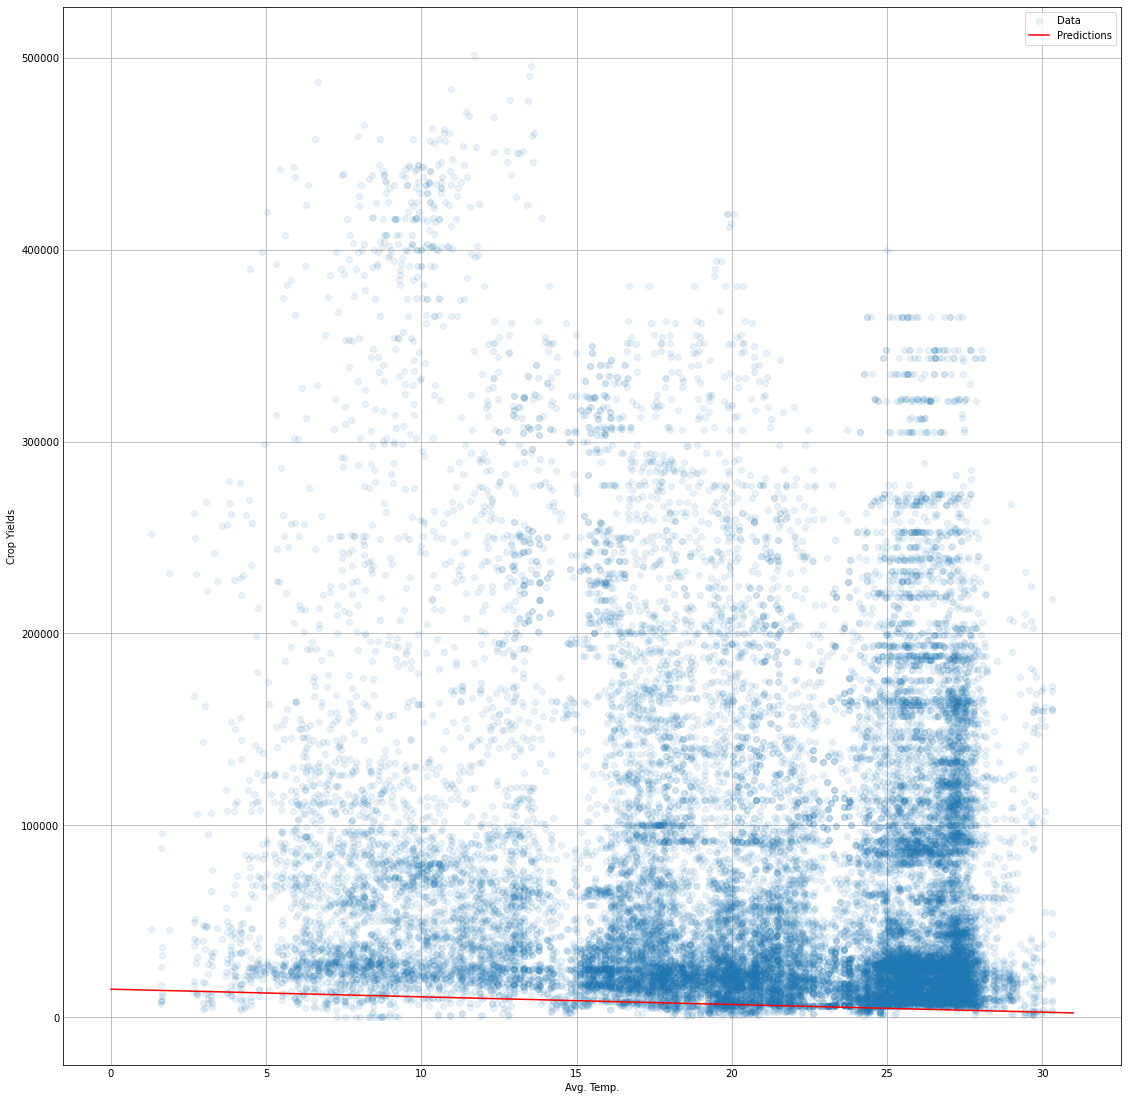

In [267]:
max_temp = math.ceil(avg_temp.max())
x = np.linspace(0, max_temp, max_temp+1)
y = avg_temp_model.predict(x)
plot_avg_temp(x, y)

In [420]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [274]:
linear_model = keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_8 (Normalizat  (None, 114)              229       
 ion)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 115       
                                                                 
Total params: 344
Trainable params: 115
Non-trainable params: 229
_________________________________________________________________


In [291]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss="mean_squared_error",
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

history = linear_model.fit(train_features,
                           target,
                           epochs=100,
                           verbose=1,
                          validation_split=0.2)

Epoch 1/100
644/644 [==============================] - 4s 6ms/step - loss: 12720855040.0000 - root_mean_squared_error: 112786.7656 - val_loss: 12780911616.0000 - val_root_mean_squared_error: 113052.6953
Epoch 2/100
644/644 [==============================] - 4s 6ms/step - loss: 12685127680.0000 - root_mean_squared_error: 112628.2734 - val_loss: 12744931328.0000 - val_root_mean_squared_error: 112893.4531
Epoch 3/100
644/644 [==============================] - 4s 6ms/step - loss: 12649487360.0000 - root_mean_squared_error: 112469.9375 - val_loss: 12709029888.0000 - val_root_mean_squared_error: 112734.3438
Epoch 4/100
644/644 [==============================] - 4s 6ms/step - loss: 12613960704.0000 - root_mean_squared_error: 112311.8906 - val_loss: 12673289216.0000 - val_root_mean_squared_error: 112575.7109
Epoch 5/100
644/644 [==============================] - 4s 6ms/step - loss: 12578658304.0000 - root_mean_squared_error: 112154.6172 - val_loss: 12637839360.0000 - val_root_mean_squared_erro

644/644 [==============================] - 4s 6ms/step - loss: 11392757760.0000 - root_mean_squared_error: 106736.8672 - val_loss: 11444444160.0000 - val_root_mean_squared_error: 106978.7109
Epoch 42/100
644/644 [==============================] - 4s 6ms/step - loss: 11361801216.0000 - root_mean_squared_error: 106591.7578 - val_loss: 11413432320.0000 - val_root_mean_squared_error: 106833.6719
Epoch 43/100
644/644 [==============================] - 4s 6ms/step - loss: 11331001344.0000 - root_mean_squared_error: 106447.1719 - val_loss: 11382393856.0000 - val_root_mean_squared_error: 106688.3047
Epoch 44/100
644/644 [==============================] - 4s 6ms/step - loss: 11300288512.0000 - root_mean_squared_error: 106302.8125 - val_loss: 11351529472.0000 - val_root_mean_squared_error: 106543.5547
Epoch 45/100
644/644 [==============================] - 4s 6ms/step - loss: 11269572608.0000 - root_mean_squared_error: 106158.2422 - val_loss: 11320579072.0000 - val_root_mean_squared_error: 10639

644/644 [==============================] - 4s 6ms/step - loss: 10227444736.0000 - root_mean_squared_error: 101130.8359 - val_loss: 10273104896.0000 - val_root_mean_squared_error: 101356.3203
Epoch 82/100
644/644 [==============================] - 4s 6ms/step - loss: 10200031232.0000 - root_mean_squared_error: 100995.2031 - val_loss: 10245634048.0000 - val_root_mean_squared_error: 101220.7266
Epoch 83/100
644/644 [==============================] - 4s 6ms/step - loss: 10172798976.0000 - root_mean_squared_error: 100860.2969 - val_loss: 10218228736.0000 - val_root_mean_squared_error: 101085.2578
Epoch 84/100
644/644 [==============================] - 4s 6ms/step - loss: 10145551360.0000 - root_mean_squared_error: 100725.1328 - val_loss: 10190992384.0000 - val_root_mean_squared_error: 100950.4453
Epoch 85/100
644/644 [==============================] - 4s 6ms/step - loss: 10118457344.0000 - root_mean_squared_error: 100590.5469 - val_loss: 10163755008.0000 - val_root_mean_squared_error: 10081

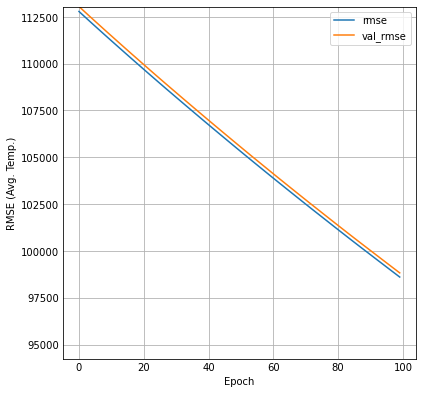

In [301]:
plot_loss(history)

In [304]:
normalizer_without_countries = tf.keras.layers.Normalization(axis=-1)
normalizer_without_countries.adapt(np.array(train_features_without_country))

In [307]:
linear_model_without_countries = keras.Sequential([
    normalizer_without_countries,
    layers.Dense(units=1)
])

linear_model_without_countries.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_9 (Normalizat  (None, 14)               29        
 ion)                                                            
                                                                 
 dense_5 (Dense)             (None, 1)                 15        
                                                                 
Total params: 44
Trainable params: 15
Non-trainable params: 29
_________________________________________________________________


In [309]:
linear_model_without_countries.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.1),
    loss="mean_squared_error",
    metrics=[keras.metrics.RootMeanSquaredError()]
)

history = linear_model_without_countries.fit(train_features_without_country,
                                            target,
                                            epochs=100,
                                            verbose=1,
                                            validation_split=0.2)

Epoch 1/100
644/644 [==============================] - 4s 6ms/step - loss: 12733659136.0000 - root_mean_squared_error: 112843.5234 - val_loss: 12807365632.0000 - val_root_mean_squared_error: 113169.6328
Epoch 2/100
644/644 [==============================] - 4s 6ms/step - loss: 12724091904.0000 - root_mean_squared_error: 112801.1172 - val_loss: 12797760512.0000 - val_root_mean_squared_error: 113127.1875
Epoch 3/100
644/644 [==============================] - 4s 6ms/step - loss: 12714486784.0000 - root_mean_squared_error: 112758.5312 - val_loss: 12788152320.0000 - val_root_mean_squared_error: 113084.7188
Epoch 4/100
644/644 [==============================] - 4s 6ms/step - loss: 12704902144.0000 - root_mean_squared_error: 112716.0312 - val_loss: 12778580992.0000 - val_root_mean_squared_error: 113042.3828
Epoch 5/100
644/644 [==============================] - 4s 6ms/step - loss: 12695350272.0000 - root_mean_squared_error: 112673.6484 - val_loss: 12769021952.0000 - val_root_mean_squared_erro

644/644 [==============================] - 4s 6ms/step - loss: 12356847616.0000 - root_mean_squared_error: 111161.3594 - val_loss: 12430494720.0000 - val_root_mean_squared_error: 111492.1250
Epoch 42/100
644/644 [==============================] - 4s 6ms/step - loss: 12347579392.0000 - root_mean_squared_error: 111119.6641 - val_loss: 12421218304.0000 - val_root_mean_squared_error: 111450.5234
Epoch 43/100
644/644 [==============================] - 4s 6ms/step - loss: 12338330624.0000 - root_mean_squared_error: 111078.0391 - val_loss: 12411968512.0000 - val_root_mean_squared_error: 111409.0156
Epoch 44/100
644/644 [==============================] - 4s 6ms/step - loss: 12329079808.0000 - root_mean_squared_error: 111036.3906 - val_loss: 12402729984.0000 - val_root_mean_squared_error: 111367.5391
Epoch 45/100
644/644 [==============================] - 4s 6ms/step - loss: 12319873024.0000 - root_mean_squared_error: 110994.9219 - val_loss: 12393497600.0000 - val_root_mean_squared_error: 11132

644/644 [==============================] - 4s 6ms/step - loss: 11993490432.0000 - root_mean_squared_error: 109514.8047 - val_loss: 12067012608.0000 - val_root_mean_squared_error: 109849.9609
Epoch 82/100
644/644 [==============================] - 4s 6ms/step - loss: 11984571392.0000 - root_mean_squared_error: 109474.0703 - val_loss: 12058091520.0000 - val_root_mean_squared_error: 109809.3359
Epoch 83/100
644/644 [==============================] - 4s 6ms/step - loss: 11975667712.0000 - root_mean_squared_error: 109433.3984 - val_loss: 12049171456.0000 - val_root_mean_squared_error: 109768.7188
Epoch 84/100
644/644 [==============================] - 4s 6ms/step - loss: 11966770176.0000 - root_mean_squared_error: 109392.7344 - val_loss: 12040296448.0000 - val_root_mean_squared_error: 109728.2891
Epoch 85/100
644/644 [==============================] - 4s 6ms/step - loss: 11957897216.0000 - root_mean_squared_error: 109352.1797 - val_loss: 12031398912.0000 - val_root_mean_squared_error: 10968

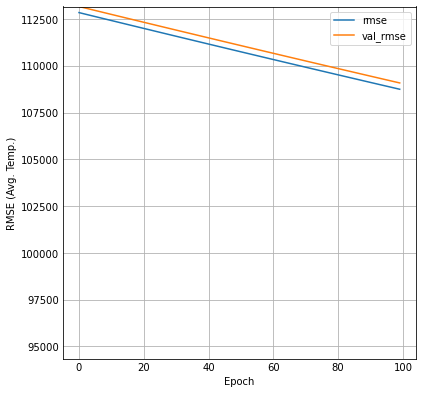

In [310]:
plot_loss(history)

<font size=10><h1 align="center">MAIN</h1></font>

In [ ]:
# Learning rate decay
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.01,
  decay_steps=10,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

In [407]:
# Tensorboard thingy
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [ ]:
# Compilation of model
def build_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activatin="relu"),
        layers.Dense(1)
    ])

    return model

In [767]:
# Compilation and fitting, returning history.
def compile_and_fit(model, name):
    
    model.compile(
        optimizer=keras.optimizers.Adam(0.1),
        loss="mean_squared_error",
        metrics=[keras.metrics.RootMeanSquaredError(),
                keras.metrics.MeanAbsoluteError()]
    )
    
    history = model.fit(train_features,
                       target,
                       epochs=50,
                       verbose=1,
                       validation_split=0.2)
    
    return history
    
    

In [768]:
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(train_features)

In [769]:

model = build_model(normalizer)
dnn_history = compile_and_fit(model, "name")

Epoch 1/50
644/644 [==============================] - 5s 8ms/step - loss: 3761905152.0000 - root_mean_squared_error: 61334.3711 - mean_absolute_error: 35343.0312 - val_loss: 1383334784.0000 - val_root_mean_squared_error: 37193.2109 - val_mean_absolute_error: 23287.3242
Epoch 2/50
644/644 [==============================] - 5s 7ms/step - loss: 1020638592.0000 - root_mean_squared_error: 31947.4336 - mean_absolute_error: 20027.5117 - val_loss: 847420160.0000 - val_root_mean_squared_error: 29110.4824 - val_mean_absolute_error: 18056.6934
Epoch 3/50
644/644 [==============================] - 5s 7ms/step - loss: 779941760.0000 - root_mean_squared_error: 27927.4395 - mean_absolute_error: 17023.8496 - val_loss: 732952128.0000 - val_root_mean_squared_error: 27073.0898 - val_mean_absolute_error: 16200.5986
Epoch 4/50
644/644 [==============================] - 5s 7ms/step - loss: 679372288.0000 - root_mean_squared_error: 26064.7715 - mean_absolute_error: 15388.0977 - val_loss: 665320896.0000 - val

Epoch 32/50
644/644 [==============================] - 5s 8ms/step - loss: 162917008.0000 - root_mean_squared_error: 12763.8945 - mean_absolute_error: 6637.7090 - val_loss: 183985664.0000 - val_root_mean_squared_error: 13564.1318 - val_mean_absolute_error: 6882.9878
Epoch 33/50
644/644 [==============================] - 5s 7ms/step - loss: 163848656.0000 - root_mean_squared_error: 12800.3389 - mean_absolute_error: 6635.1680 - val_loss: 185297936.0000 - val_root_mean_squared_error: 13612.4180 - val_mean_absolute_error: 6840.1304
Epoch 34/50
644/644 [==============================] - 5s 7ms/step - loss: 163297344.0000 - root_mean_squared_error: 12778.7861 - mean_absolute_error: 6573.2993 - val_loss: 179445808.0000 - val_root_mean_squared_error: 13395.7383 - val_mean_absolute_error: 6910.1479
Epoch 35/50
644/644 [==============================] - 5s 8ms/step - loss: 161136176.0000 - root_mean_squared_error: 12693.9424 - mean_absolute_error: 6541.9917 - val_loss: 185433024.0000 - val_root_

In [411]:
model_histories = {}

In [418]:
model = build_model(normalizer)
model_histories["64_unit_hidden_layer"] = compile_and_fit(model, "64_unit_hidden_layer")


Epoch 1/500
644/644 [==============================] - ETA: 0s - loss: 12738026496.0000 - root_mean_squared_error: 112862.8672
Epoch: 0, loss:12738026496.0000,  root_mean_squared_error:112862.8672,  val_loss:12816442368.0000,  val_root_mean_squared_error:113209.7344,  
644/644 [==============================] - 5s 7ms/step - loss: 12738026496.0000 - root_mean_squared_error: 112862.8672 - val_loss: 12816442368.0000 - val_root_mean_squared_error: 113209.7344
Epoch 2/500
382/644 [================>.............] - ETA: 1s - loss: 12599811072.0000 - root_mean_squared_error: 112248.8828

KeyboardInterrupt: 

In [424]:
dnn_experiment2 = keras.Sequential([
    normalizer,
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(1)
])

dnn_experiment2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.05),
                       loss="mean_squared_error",
                       metrics=[keras.metrics.RootMeanSquaredError()])

history = dnn_experiment2.fit(train_features,
                             target,
                             epochs=300,
                             validation_split=0.2,
                             verbose=1)

Epoch 1/300
644/644 [==============================] - 5s 8ms/step - loss: 1517594112.0000 - root_mean_squared_error: 38956.3086 - val_loss: 683911616.0000 - val_root_mean_squared_error: 26151.7051
Epoch 2/300
644/644 [==============================] - 5s 7ms/step - loss: 524052352.0000 - root_mean_squared_error: 22892.1895 - val_loss: 409283264.0000 - val_root_mean_squared_error: 20230.7520
Epoch 3/300
644/644 [==============================] - 5s 7ms/step - loss: 353951904.0000 - root_mean_squared_error: 18813.6094 - val_loss: 327071232.0000 - val_root_mean_squared_error: 18085.1113
Epoch 4/300
644/644 [==============================] - 5s 7ms/step - loss: 306520704.0000 - root_mean_squared_error: 17507.7324 - val_loss: 303614400.0000 - val_root_mean_squared_error: 17424.5332
Epoch 5/300
644/644 [==============================] - 5s 8ms/step - loss: 276251840.0000 - root_mean_squared_error: 16620.8262 - val_loss: 264854928.0000 - val_root_mean_squared_error: 16274.3643
Epoch 6/300
64

644/644 [==============================] - 5s 7ms/step - loss: 106070856.0000 - root_mean_squared_error: 10299.0703 - val_loss: 112046088.0000 - val_root_mean_squared_error: 10585.1826
Epoch 43/300
644/644 [==============================] - 5s 7ms/step - loss: 110041640.0000 - root_mean_squared_error: 10490.0742 - val_loss: 102909112.0000 - val_root_mean_squared_error: 10144.4131
Epoch 44/300
644/644 [==============================] - 5s 8ms/step - loss: 100404552.0000 - root_mean_squared_error: 10020.2070 - val_loss: 117182416.0000 - val_root_mean_squared_error: 10825.0830
Epoch 45/300
644/644 [==============================] - 5s 8ms/step - loss: 102352232.0000 - root_mean_squared_error: 10116.9277 - val_loss: 118723776.0000 - val_root_mean_squared_error: 10896.0439
Epoch 46/300
644/644 [==============================] - 5s 7ms/step - loss: 100870944.0000 - root_mean_squared_error: 10043.4531 - val_loss: 114829312.0000 - val_root_mean_squared_error: 10715.8438
Epoch 47/300
644/644 [=

Epoch 84/300
644/644 [==============================] - 5s 8ms/step - loss: 77072864.0000 - root_mean_squared_error: 8779.1152 - val_loss: 87223304.0000 - val_root_mean_squared_error: 9339.3418
Epoch 85/300
644/644 [==============================] - 5s 7ms/step - loss: 81320448.0000 - root_mean_squared_error: 9017.7852 - val_loss: 91948488.0000 - val_root_mean_squared_error: 9588.9775
Epoch 86/300
644/644 [==============================] - 5s 8ms/step - loss: 78727224.0000 - root_mean_squared_error: 8872.8369 - val_loss: 94870544.0000 - val_root_mean_squared_error: 9740.1514
Epoch 87/300
644/644 [==============================] - 5s 7ms/step - loss: 78162528.0000 - root_mean_squared_error: 8840.9570 - val_loss: 91476632.0000 - val_root_mean_squared_error: 9564.3418
Epoch 88/300
644/644 [==============================] - 5s 7ms/step - loss: 78160336.0000 - root_mean_squared_error: 8840.8330 - val_loss: 96723840.0000 - val_root_mean_squared_error: 9834.8281
Epoch 89/300
644/644 [========

644/644 [==============================] - 5s 8ms/step - loss: 70057168.0000 - root_mean_squared_error: 8370.0156 - val_loss: 89156528.0000 - val_root_mean_squared_error: 9442.2734
Epoch 127/300
644/644 [==============================] - 5s 8ms/step - loss: 71015712.0000 - root_mean_squared_error: 8427.0820 - val_loss: 85477744.0000 - val_root_mean_squared_error: 9245.4180
Epoch 128/300
644/644 [==============================] - 5s 7ms/step - loss: 67530208.0000 - root_mean_squared_error: 8217.6768 - val_loss: 86196248.0000 - val_root_mean_squared_error: 9284.1934
Epoch 129/300
644/644 [==============================] - 5s 7ms/step - loss: 70626080.0000 - root_mean_squared_error: 8403.9326 - val_loss: 91308024.0000 - val_root_mean_squared_error: 9555.5234
Epoch 130/300
644/644 [==============================] - 5s 7ms/step - loss: 67798952.0000 - root_mean_squared_error: 8234.0117 - val_loss: 93232128.0000 - val_root_mean_squared_error: 9655.6787
Epoch 131/300
644/644 [================

644/644 [==============================] - 5s 7ms/step - loss: 64056332.0000 - root_mean_squared_error: 8003.5200 - val_loss: 81377280.0000 - val_root_mean_squared_error: 9020.9355
Epoch 169/300
644/644 [==============================] - 5s 7ms/step - loss: 62658172.0000 - root_mean_squared_error: 7915.6914 - val_loss: 88398184.0000 - val_root_mean_squared_error: 9402.0312
Epoch 170/300
644/644 [==============================] - 5s 7ms/step - loss: 64335164.0000 - root_mean_squared_error: 8020.9204 - val_loss: 85928256.0000 - val_root_mean_squared_error: 9269.7490
Epoch 171/300
644/644 [==============================] - 5s 7ms/step - loss: 62228184.0000 - root_mean_squared_error: 7888.4849 - val_loss: 86794360.0000 - val_root_mean_squared_error: 9316.3496
Epoch 172/300
644/644 [==============================] - 5s 8ms/step - loss: 61552124.0000 - root_mean_squared_error: 7845.5166 - val_loss: 83434408.0000 - val_root_mean_squared_error: 9134.2441
Epoch 173/300
644/644 [================

644/644 [==============================] - 5s 7ms/step - loss: 58779516.0000 - root_mean_squared_error: 7666.7803 - val_loss: 82172656.0000 - val_root_mean_squared_error: 9064.9131
Epoch 211/300
644/644 [==============================] - 5s 7ms/step - loss: 58433772.0000 - root_mean_squared_error: 7644.1987 - val_loss: 82934080.0000 - val_root_mean_squared_error: 9106.8154
Epoch 212/300
644/644 [==============================] - 5s 7ms/step - loss: 58732068.0000 - root_mean_squared_error: 7663.6855 - val_loss: 82505712.0000 - val_root_mean_squared_error: 9083.2656
Epoch 213/300
644/644 [==============================] - 5s 7ms/step - loss: 58861344.0000 - root_mean_squared_error: 7672.1147 - val_loss: 90238640.0000 - val_root_mean_squared_error: 9499.4023
Epoch 214/300
644/644 [==============================] - 5s 7ms/step - loss: 57959636.0000 - root_mean_squared_error: 7613.1226 - val_loss: 83736288.0000 - val_root_mean_squared_error: 9150.7539
Epoch 215/300
644/644 [================

644/644 [==============================] - 5s 8ms/step - loss: 54230600.0000 - root_mean_squared_error: 7364.1431 - val_loss: 94784776.0000 - val_root_mean_squared_error: 9735.7471
Epoch 253/300
644/644 [==============================] - 4s 7ms/step - loss: 54637684.0000 - root_mean_squared_error: 7391.7310 - val_loss: 87217648.0000 - val_root_mean_squared_error: 9339.0391
Epoch 254/300
644/644 [==============================] - 4s 7ms/step - loss: 55813936.0000 - root_mean_squared_error: 7470.8726 - val_loss: 98499696.0000 - val_root_mean_squared_error: 9924.7012
Epoch 255/300
644/644 [==============================] - 4s 7ms/step - loss: 55179944.0000 - root_mean_squared_error: 7428.3208 - val_loss: 87012608.0000 - val_root_mean_squared_error: 9328.0547
Epoch 256/300
644/644 [==============================] - 4s 7ms/step - loss: 55423368.0000 - root_mean_squared_error: 7444.6875 - val_loss: 82129696.0000 - val_root_mean_squared_error: 9062.5439
Epoch 257/300
644/644 [================

644/644 [==============================] - 5s 7ms/step - loss: 52104384.0000 - root_mean_squared_error: 7218.3374 - val_loss: 79792712.0000 - val_root_mean_squared_error: 8932.6768
Epoch 295/300
644/644 [==============================] - 5s 7ms/step - loss: 51493244.0000 - root_mean_squared_error: 7175.8794 - val_loss: 74643096.0000 - val_root_mean_squared_error: 8639.6240
Epoch 296/300
644/644 [==============================] - 5s 7ms/step - loss: 53069392.0000 - root_mean_squared_error: 7284.8745 - val_loss: 78194864.0000 - val_root_mean_squared_error: 8842.7861
Epoch 297/300
644/644 [==============================] - 5s 7ms/step - loss: 50507692.0000 - root_mean_squared_error: 7106.8765 - val_loss: 79514152.0000 - val_root_mean_squared_error: 8917.0713
Epoch 298/300
644/644 [==============================] - 5s 7ms/step - loss: 52579032.0000 - root_mean_squared_error: 7251.1406 - val_loss: 77578256.0000 - val_root_mean_squared_error: 8807.8516
Epoch 299/300
644/644 [================

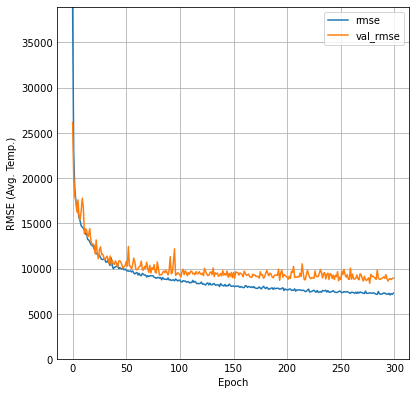

In [425]:
plot_loss(history)

In [426]:
dnn_experiment3 = keras.Sequential([
    normalizer,
    layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l1(0.01)),
    layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l1(0.01)),
    layers.Dense(1)
])

dnn_experiment3.compile(optimizer=keras.optimizers.Adam(0.1),
                       loss="mean_squared_error",
                       metrics=[keras.metrics.RootMeanSquaredError()])

dnn_experiment3.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_10 (Normaliza  (None, 114)              229       
 tion)                                                           
                                                                 
 dense_71 (Dense)            (None, 512)               58880     
                                                                 
 dense_72 (Dense)            (None, 512)               262656    
                                                                 
 dense_73 (Dense)            (None, 1)                 513       
                                                                 
Total params: 322,278
Trainable params: 322,049
Non-trainable params: 229
_________________________________________________________________


In [427]:
experiment3_history = dnn_experiment3.fit(train_features,
                                         target,
                                         epochs=300,
                                         verbose=1,
                                         validation_split=0.2)

Epoch 1/300
644/644 [==============================] - 9s 11ms/step - loss: 1146983040.0000 - root_mean_squared_error: 33867.1133 - val_loss: 893762368.0000 - val_root_mean_squared_error: 29895.8281
Epoch 2/300
644/644 [==============================] - 7s 10ms/step - loss: 516931744.0000 - root_mean_squared_error: 22736.0879 - val_loss: 404985856.0000 - val_root_mean_squared_error: 20124.2129
Epoch 3/300
644/644 [==============================] - 7s 10ms/step - loss: 385692992.0000 - root_mean_squared_error: 19639.0254 - val_loss: 333750880.0000 - val_root_mean_squared_error: 18268.8008
Epoch 4/300
644/644 [==============================] - 8s 13ms/step - loss: 324952224.0000 - root_mean_squared_error: 18026.3750 - val_loss: 269593792.0000 - val_root_mean_squared_error: 16419.2441
Epoch 5/300
644/644 [==============================] - 7s 10ms/step - loss: 275539904.0000 - root_mean_squared_error: 16599.3223 - val_loss: 280358592.0000 - val_root_mean_squared_error: 16743.8398
Epoch 6/3

644/644 [==============================] - 6s 9ms/step - loss: 101491608.0000 - root_mean_squared_error: 10073.8594 - val_loss: 114420200.0000 - val_root_mean_squared_error: 10696.3164
Epoch 43/300
644/644 [==============================] - 6s 9ms/step - loss: 98100704.0000 - root_mean_squared_error: 9904.1221 - val_loss: 126835352.0000 - val_root_mean_squared_error: 11261.7139
Epoch 44/300
644/644 [==============================] - 6s 10ms/step - loss: 98458704.0000 - root_mean_squared_error: 9922.1699 - val_loss: 122105832.0000 - val_root_mean_squared_error: 11049.7285
Epoch 45/300
644/644 [==============================] - 6s 9ms/step - loss: 95427160.0000 - root_mean_squared_error: 9768.2012 - val_loss: 135822336.0000 - val_root_mean_squared_error: 11653.8730
Epoch 46/300
644/644 [==============================] - 5s 8ms/step - loss: 98104752.0000 - root_mean_squared_error: 9904.3057 - val_loss: 141080224.0000 - val_root_mean_squared_error: 11877.3086
Epoch 47/300
644/644 [========

Epoch 84/300
644/644 [==============================] - 5s 8ms/step - loss: 82186208.0000 - root_mean_squared_error: 9064.6562 - val_loss: 102853656.0000 - val_root_mean_squared_error: 10140.7754
Epoch 85/300
644/644 [==============================] - 5s 8ms/step - loss: 85558920.0000 - root_mean_squared_error: 9248.8115 - val_loss: 91417776.0000 - val_root_mean_squared_error: 9560.2969
Epoch 86/300
644/644 [==============================] - 5s 8ms/step - loss: 84343144.0000 - root_mean_squared_error: 9182.8350 - val_loss: 100280320.0000 - val_root_mean_squared_error: 10013.0713
Epoch 87/300
644/644 [==============================] - 5s 8ms/step - loss: 79184376.0000 - root_mean_squared_error: 8897.4971 - val_loss: 97770800.0000 - val_root_mean_squared_error: 9886.9521
Epoch 88/300
644/644 [==============================] - 5s 8ms/step - loss: 80352792.0000 - root_mean_squared_error: 8962.9102 - val_loss: 90804944.0000 - val_root_mean_squared_error: 9528.1543
Epoch 89/300
644/644 [====

Epoch 126/300
644/644 [==============================] - 5s 8ms/step - loss: 78338984.0000 - root_mean_squared_error: 8849.2939 - val_loss: 105683296.0000 - val_root_mean_squared_error: 10278.8232
Epoch 127/300
644/644 [==============================] - 5s 8ms/step - loss: 74743680.0000 - root_mean_squared_error: 8643.7568 - val_loss: 86334040.0000 - val_root_mean_squared_error: 9290.0293
Epoch 128/300
644/644 [==============================] - 5s 8ms/step - loss: 74485456.0000 - root_mean_squared_error: 8628.7900 - val_loss: 94863000.0000 - val_root_mean_squared_error: 9738.2432
Epoch 129/300
644/644 [==============================] - 5s 8ms/step - loss: 72653088.0000 - root_mean_squared_error: 8521.9395 - val_loss: 112523656.0000 - val_root_mean_squared_error: 10606.3096
Epoch 130/300
644/644 [==============================] - 5s 8ms/step - loss: 75899112.0000 - root_mean_squared_error: 8710.2891 - val_loss: 92326048.0000 - val_root_mean_squared_error: 9607.0742
Epoch 131/300
644/644

Epoch 168/300
644/644 [==============================] - 5s 8ms/step - loss: 70650328.0000 - root_mean_squared_error: 8402.9941 - val_loss: 83346040.0000 - val_root_mean_squared_error: 9127.2090
Epoch 169/300
644/644 [==============================] - 5s 8ms/step - loss: 70743584.0000 - root_mean_squared_error: 8408.5264 - val_loss: 94732976.0000 - val_root_mean_squared_error: 9731.0127
Epoch 170/300
644/644 [==============================] - 5s 8ms/step - loss: 75285240.0000 - root_mean_squared_error: 8674.3730 - val_loss: 97338408.0000 - val_root_mean_squared_error: 9863.9648
Epoch 171/300
644/644 [==============================] - 5s 8ms/step - loss: 69467512.0000 - root_mean_squared_error: 8332.2725 - val_loss: 99553552.0000 - val_root_mean_squared_error: 9975.6055
Epoch 172/300
644/644 [==============================] - 5s 8ms/step - loss: 71519968.0000 - root_mean_squared_error: 8454.5254 - val_loss: 91226304.0000 - val_root_mean_squared_error: 9549.0918
Epoch 173/300
644/644 [==

KeyboardInterrupt: 

In [390]:
%%time
dnn_experiment = build_and_compile_model(normalizer)
hist_y = dnn_experiment.fit(train_features,
                                    target,
                                    epochs=1000,
                                    verbose=1,
                                    validation_split=0.2)


Epoch 1/1000
644/644 [==============================] - 5s 7ms/step - loss: 12726171648.0000 - root_mean_squared_error: 112810.3438 - val_loss: 12778263552.0000 - val_root_mean_squared_error: 113040.9844
Epoch 2/1000
644/644 [==============================] - 4s 6ms/step - loss: 12645365760.0000 - root_mean_squared_error: 112451.6172 - val_loss: 12651501568.0000 - val_root_mean_squared_error: 112478.8984
Epoch 3/1000
644/644 [==============================] - 4s 7ms/step - loss: 12479374336.0000 - root_mean_squared_error: 111711.1250 - val_loss: 12444040192.0000 - val_root_mean_squared_error: 111552.8594
Epoch 4/1000
644/644 [==============================] - 4s 7ms/step - loss: 12246388736.0000 - root_mean_squared_error: 110663.3984 - val_loss: 12180648960.0000 - val_root_mean_squared_error: 110365.9844
Epoch 5/1000
644/644 [==============================] - 4s 7ms/step - loss: 11964289024.0000 - root_mean_squared_error: 109381.3906 - val_loss: 11870573568.0000 - val_root_mean_squared

644/644 [==============================] - 4s 7ms/step - loss: 1842267264.0000 - root_mean_squared_error: 42921.6406 - val_loss: 1771293312.0000 - val_root_mean_squared_error: 42086.7383
Epoch 42/1000
644/644 [==============================] - 4s 7ms/step - loss: 1800537088.0000 - root_mean_squared_error: 42432.7344 - val_loss: 1731796352.0000 - val_root_mean_squared_error: 41614.8594
Epoch 43/1000
644/644 [==============================] - 4s 7ms/step - loss: 1762390272.0000 - root_mean_squared_error: 41980.8320 - val_loss: 1696013056.0000 - val_root_mean_squared_error: 41182.6797
Epoch 44/1000
644/644 [==============================] - 4s 7ms/step - loss: 1727654400.0000 - root_mean_squared_error: 41565.0625 - val_loss: 1663412864.0000 - val_root_mean_squared_error: 40784.9609
Epoch 45/1000
644/644 [==============================] - 4s 7ms/step - loss: 1695704448.0000 - root_mean_squared_error: 41178.9336 - val_loss: 1633669760.0000 - val_root_mean_squared_error: 40418.6797
Epoch 46/

KeyboardInterrupt: 

<h1>Convolutional Neural Network for Regression</h1>

In [ ]:
num_features

In [ ]:
cnn = keras.Sequential([
    normalizer, 
    layers.Conv1D(32, 3, activation="relu", input_shape=train_features.shape),
    layers.MaxPool1D       
])

In [346]:
avg_temp_dnn = build_and_compile_model(avg_temp_normalizer)
avg_temp_dnn.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_22 (Dense)            (None, 128)               256       
                                                                 
 dense_23 (Dense)            (None, 128)               16512     
                                                                 
 dense_24 (Dense)            (None, 1)                 129       
                                                                 
Total params: 16,900
Trainable params: 16,897
Non-trainable params: 3
_________________________________________________________________


In [325]:
%%time
avg_temp_dnn_history = avg_temp_dnn.fit(train_features["avg_temp"],
                                        target,
                                        epochs=100,
                                        verbose=1,
                                        validation_split=0.2)

Epoch 1/100
644/644 [==============================] - 5s 7ms/step - loss: 6884674048.0000 - root_mean_squared_error: 82973.9375 - val_loss: 6943731712.0000 - val_root_mean_squared_error: 83329.0625
Epoch 2/100
644/644 [==============================] - 5s 7ms/step - loss: 6887186944.0000 - root_mean_squared_error: 82989.0781 - val_loss: 6941410816.0000 - val_root_mean_squared_error: 83315.1328
Epoch 3/100
644/644 [==============================] - 5s 7ms/step - loss: 6880564224.0000 - root_mean_squared_error: 82949.1641 - val_loss: 6941071872.0000 - val_root_mean_squared_error: 83313.1016
Epoch 4/100
644/644 [==============================] - 5s 7ms/step - loss: 6881950208.0000 - root_mean_squared_error: 82957.5234 - val_loss: 6960987648.0000 - val_root_mean_squared_error: 83432.5312
Epoch 5/100
644/644 [==============================] - 5s 7ms/step - loss: 6882117120.0000 - root_mean_squared_error: 82958.5312 - val_loss: 6938434560.0000 - val_root_mean_squared_error: 83297.2656
Epoch

644/644 [==============================] - 5s 7ms/step - loss: 6871789056.0000 - root_mean_squared_error: 82896.2578 - val_loss: 6942725120.0000 - val_root_mean_squared_error: 83323.0156
Epoch 43/100
644/644 [==============================] - 4s 7ms/step - loss: 6875265024.0000 - root_mean_squared_error: 82917.2188 - val_loss: 6935202816.0000 - val_root_mean_squared_error: 83277.8672
Epoch 44/100
644/644 [==============================] - 5s 7ms/step - loss: 6873512960.0000 - root_mean_squared_error: 82906.6562 - val_loss: 6933998080.0000 - val_root_mean_squared_error: 83270.6328
Epoch 45/100
644/644 [==============================] - 5s 7ms/step - loss: 6873130496.0000 - root_mean_squared_error: 82904.3516 - val_loss: 6934968832.0000 - val_root_mean_squared_error: 83276.4609
Epoch 46/100
644/644 [==============================] - 5s 7ms/step - loss: 6875006976.0000 - root_mean_squared_error: 82915.6641 - val_loss: 6939358208.0000 - val_root_mean_squared_error: 83302.8125
Epoch 47/100


644/644 [==============================] - 5s 7ms/step - loss: 6872212480.0000 - root_mean_squared_error: 82898.8125 - val_loss: 6938966016.0000 - val_root_mean_squared_error: 83300.4531
Epoch 84/100
644/644 [==============================] - 5s 7ms/step - loss: 6874970624.0000 - root_mean_squared_error: 82915.4453 - val_loss: 6938598400.0000 - val_root_mean_squared_error: 83298.2500
Epoch 85/100
644/644 [==============================] - 4s 7ms/step - loss: 6875883008.0000 - root_mean_squared_error: 82920.9453 - val_loss: 6936552960.0000 - val_root_mean_squared_error: 83285.9766
Epoch 86/100
644/644 [==============================] - 5s 7ms/step - loss: 6875019264.0000 - root_mean_squared_error: 82915.7422 - val_loss: 6938049536.0000 - val_root_mean_squared_error: 83294.9531
Epoch 87/100
644/644 [==============================] - 5s 7ms/step - loss: 6873073152.0000 - root_mean_squared_error: 82904.0000 - val_loss: 6932611072.0000 - val_root_mean_squared_error: 83262.3047
Epoch 88/100


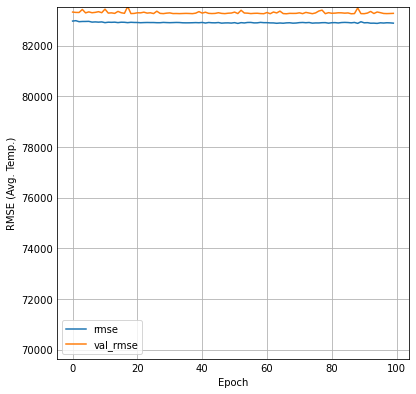

In [326]:
plot_loss(avg_temp_dnn_history)

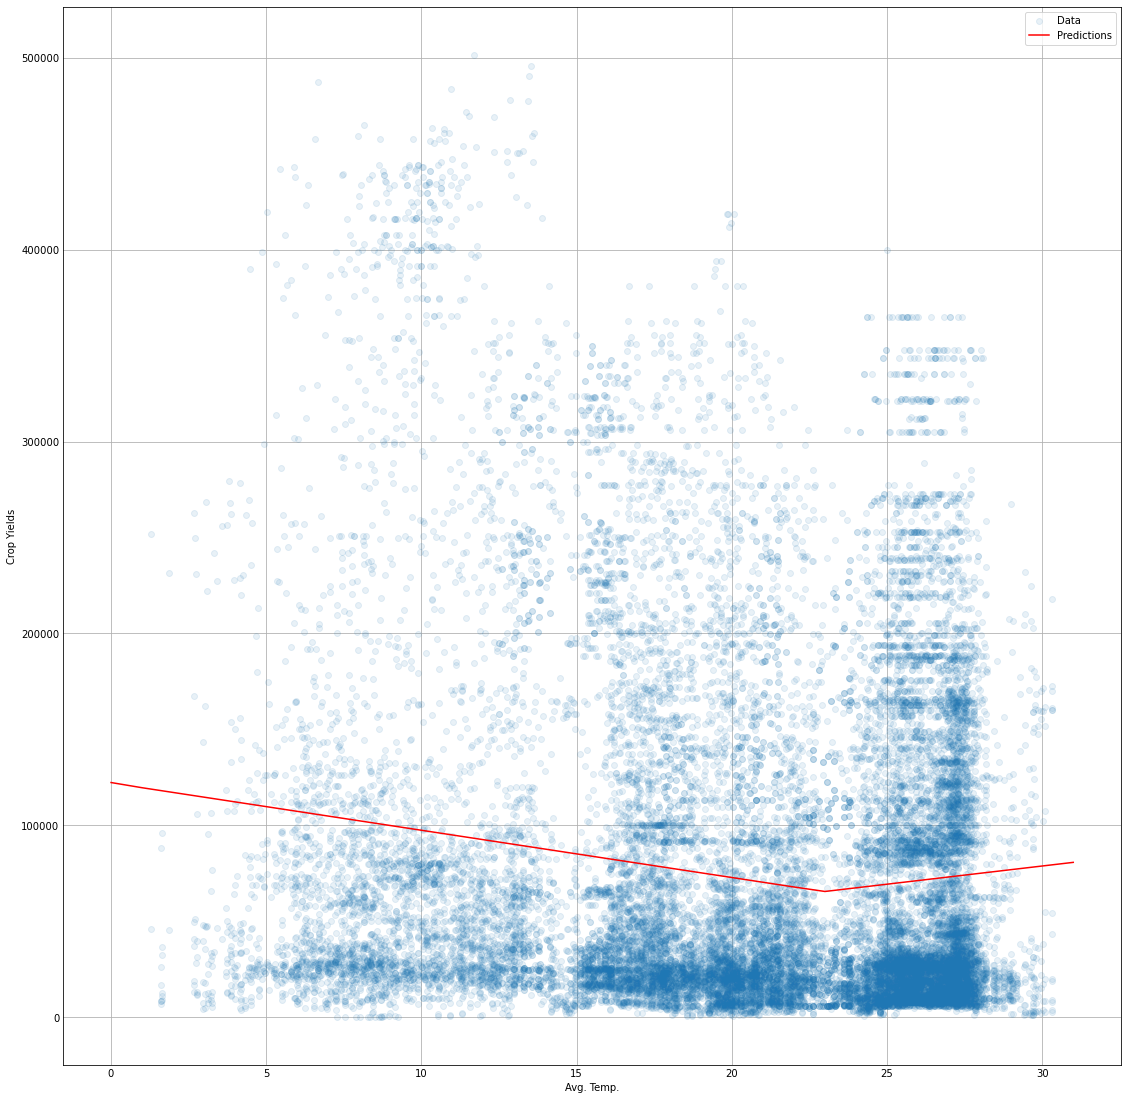

In [328]:
max_temp = math.ceil(avg_temp.max())
x = np.linspace(0, max_temp, max_temp+1)
y = avg_temp_dnn.predict(x)
plot_avg_temp(x, y);

In [347]:
dnn = build_and_compile_model(normalizer)
dnn.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_8 (Normalizat  (None, 114)              229       
 ion)                                                            
                                                                 
 dense_25 (Dense)            (None, 128)               14720     
                                                                 
 dense_26 (Dense)            (None, 128)               16512     
                                                                 
 dense_27 (Dense)            (None, 1)                 129       
                                                                 
Total params: 31,590
Trainable params: 31,361
Non-trainable params: 229
_________________________________________________________________


In [348]:
dnn_history = dnn.fit(train_features,
                     target,
                     validation_split=0.2,
                     epochs=100,
                     verbose=1)

Epoch 1/100
644/644 [==============================] - 5s 8ms/step - loss: 2827515392.0000 - root_mean_squared_error: 53174.3906 - val_loss: 924750592.0000 - val_root_mean_squared_error: 30409.7129
Epoch 2/100
644/644 [==============================] - 5s 7ms/step - loss: 792516544.0000 - root_mean_squared_error: 28151.6719 - val_loss: 715726912.0000 - val_root_mean_squared_error: 26753.0742
Epoch 3/100
644/644 [==============================] - 5s 7ms/step - loss: 613556480.0000 - root_mean_squared_error: 24770.0723 - val_loss: 539038400.0000 - val_root_mean_squared_error: 23217.2012
Epoch 4/100
644/644 [==============================] - 5s 7ms/step - loss: 425267360.0000 - root_mean_squared_error: 20622.0117 - val_loss: 357863968.0000 - val_root_mean_squared_error: 18917.2930
Epoch 5/100
644/644 [==============================] - 5s 7ms/step - loss: 303497568.0000 - root_mean_squared_error: 17421.1816 - val_loss: 287277632.0000 - val_root_mean_squared_error: 16949.2676
Epoch 6/100
64

644/644 [==============================] - 5s 8ms/step - loss: 88133488.0000 - root_mean_squared_error: 9387.9434 - val_loss: 101997392.0000 - val_root_mean_squared_error: 10099.3760
Epoch 43/100
644/644 [==============================] - 5s 8ms/step - loss: 85756952.0000 - root_mean_squared_error: 9260.5049 - val_loss: 91759848.0000 - val_root_mean_squared_error: 9579.1357
Epoch 44/100
644/644 [==============================] - 5s 7ms/step - loss: 89560608.0000 - root_mean_squared_error: 9463.6475 - val_loss: 97630808.0000 - val_root_mean_squared_error: 9880.8301
Epoch 45/100
644/644 [==============================] - 4s 7ms/step - loss: 83452960.0000 - root_mean_squared_error: 9135.2598 - val_loss: 109519568.0000 - val_root_mean_squared_error: 10465.1602
Epoch 46/100
644/644 [==============================] - 5s 8ms/step - loss: 84169024.0000 - root_mean_squared_error: 9174.3682 - val_loss: 95173136.0000 - val_root_mean_squared_error: 9755.6719
Epoch 47/100
644/644 [=================

644/644 [==============================] - 5s 7ms/step - loss: 71597576.0000 - root_mean_squared_error: 8461.5352 - val_loss: 87470184.0000 - val_root_mean_squared_error: 9352.5498
Epoch 85/100
644/644 [==============================] - 5s 7ms/step - loss: 70835040.0000 - root_mean_squared_error: 8416.3555 - val_loss: 92921344.0000 - val_root_mean_squared_error: 9639.5713
Epoch 86/100
644/644 [==============================] - 5s 8ms/step - loss: 69920800.0000 - root_mean_squared_error: 8361.8662 - val_loss: 93529336.0000 - val_root_mean_squared_error: 9671.0566
Epoch 87/100
644/644 [==============================] - 5s 7ms/step - loss: 70685248.0000 - root_mean_squared_error: 8407.4521 - val_loss: 90051688.0000 - val_root_mean_squared_error: 9489.5576
Epoch 88/100
644/644 [==============================] - 5s 7ms/step - loss: 70328288.0000 - root_mean_squared_error: 8386.1963 - val_loss: 86102984.0000 - val_root_mean_squared_error: 9279.1699
Epoch 89/100
644/644 [=====================

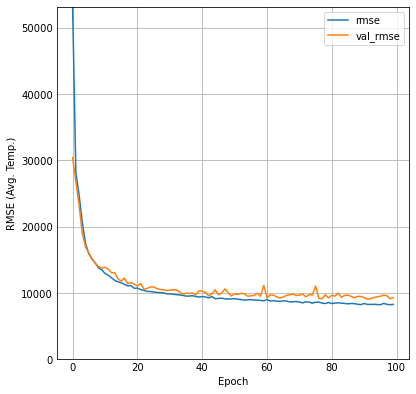

In [349]:
plot_loss(dnn_history)

<h1>DNN with Regularization</h1>

In [353]:
from keras import regularizers

In [361]:
regularized_model = keras.Sequential([
    normalizer,
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularized_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_8 (Normalizat  (None, 114)              229       
 ion)                                                            
                                                                 
 dense_34 (Dense)            (None, 128)               14720     
                                                                 
 dense_35 (Dense)            (None, 128)               16512     
                                                                 
 dense_36 (Dense)            (None, 1)                 129       
                                                                 
Total params: 31,590
Trainable params: 31,361
Non-trainable params: 229
_________________________________________________________________


In [362]:
regularized_model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss="mean_squared_error",
    metrics=[keras.metrics.RootMeanSquaredError()]
)

In [363]:
regularized_model_history = regularized_model.fit(train_features, 
                                                 target,
                                                 epochs=100,
                                                 verbose=1,
                                                 validation_split=0.2)



Epoch 1/100
644/644 [==============================] - 5s 8ms/step - loss: 10245314560.0000 - root_mean_squared_error: 101219.1406 - val_loss: 4850785792.0000 - val_root_mean_squared_error: 69647.5859
Epoch 2/100
644/644 [==============================] - 5s 7ms/step - loss: 2702665472.0000 - root_mean_squared_error: 51987.1680 - val_loss: 1791782400.0000 - val_root_mean_squared_error: 42329.4492
Epoch 3/100
644/644 [==============================] - 5s 8ms/step - loss: 1604301056.0000 - root_mean_squared_error: 40053.7266 - val_loss: 1410188416.0000 - val_root_mean_squared_error: 37552.4766
Epoch 4/100
644/644 [==============================] - 5s 8ms/step - loss: 1356749952.0000 - root_mean_squared_error: 36834.0859 - val_loss: 1253041024.0000 - val_root_mean_squared_error: 35398.3203
Epoch 5/100
644/644 [==============================] - 5s 8ms/step - loss: 1221968640.0000 - root_mean_squared_error: 34956.6680 - val_loss: 1139759360.0000 - val_root_mean_squared_error: 33760.3242
Epo

KeyboardInterrupt: 

<h1>DNN With Dropout</h1>

In [367]:
dropout_model = keras.Sequential([
    normalizer,
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1)
])

dropout_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_8 (Normalizat  (None, 114)              229       
 ion)                                                            
                                                                 
 dense_43 (Dense)            (None, 128)               14720     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_44 (Dense)            (None, 128)               16512     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_45 (Dense)            (None, 1)                 129       
                                                     

In [368]:
dropout_model.compile(
    optimizer=keras.optimizers.Adam(0.01),
    loss="mean_squared_error",
    metrics=[keras.metrics.RootMeanSquaredError()]
)

In [373]:
dropout_model_history = dropout_model.fit(train_features,
                                         target,
                                         epochs=100,
                                         verbose=1,
                                         validation_split=0.2)

Epoch 1/100
644/644 [==============================] - 5s 8ms/step - loss: 912980864.0000 - root_mean_squared_error: 30215.5723 - val_loss: 611060928.0000 - val_root_mean_squared_error: 24719.6484
Epoch 2/100
644/644 [==============================] - 5s 8ms/step - loss: 866725120.0000 - root_mean_squared_error: 29440.1953 - val_loss: 516484672.0000 - val_root_mean_squared_error: 22726.2988
Epoch 3/100
644/644 [==============================] - 5s 8ms/step - loss: 769361024.0000 - root_mean_squared_error: 27737.3574 - val_loss: 434084064.0000 - val_root_mean_squared_error: 20834.6836
Epoch 4/100
644/644 [==============================] - 5s 8ms/step - loss: 697216064.0000 - root_mean_squared_error: 26404.8496 - val_loss: 411923680.0000 - val_root_mean_squared_error: 20295.9023
Epoch 5/100
644/644 [==============================] - 5s 8ms/step - loss: 673981760.0000 - root_mean_squared_error: 25961.1602 - val_loss: 378987648.0000 - val_root_mean_squared_error: 19467.6055
Epoch 6/100
626

KeyboardInterrupt: 

In [452]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

In [436]:
train_features["Country_Sudan"] = np.zeros(len(train_features.index), dtype=np.uint8)

In [444]:
scaled_train_features = scaler.fit_transform(train_features)

In [580]:
def init_mlp():
    mlp = MLPRegressor(hidden_layer_sizes=(64, 64), 
                   learning_rate_init=0.1, 
                   alpha=0.1,
                   warm_start=True, 
                   max_iter=1)
    return mlp

In [593]:
def init_mlp_without_warm_start():
    mlp = MLPRegressor(hidden_layer_sizes=(64, 64), 
                   learning_rate_init=0.1,
                    alpha=0.001,
                   verbose=1)
    return mlp

In [554]:
def rmse(predictions, truth):
    sum_squared_error = 0
    for prediction, truth_value in zip(predictions, truth):
        squared_error = (prediction-truth_value)**2
        sum_squared_error += squared_error
    mean_squared_error = sum_squared_error / len(predictions)
    return math.sqrt(mean_squared_error)

In [594]:
mlp = init_mlp_without_warm_start()

x_train, x_val, y_train, y_val = train_test_split(scaled_train_features, train_target, test_size=0.2)
mlp.fit(x_train, y_train)

Iteration 1, loss = 2418104037.43697882
Iteration 2, loss = 462406977.34187269
Iteration 3, loss = 339872282.71545899
Iteration 4, loss = 263444048.23402137
Iteration 5, loss = 214482329.22651193
Iteration 6, loss = 189799338.77234411
Iteration 7, loss = 167382417.81609204
Iteration 8, loss = 154392831.66647252
Iteration 9, loss = 142854304.07231551
Iteration 10, loss = 133693485.43443368
Iteration 11, loss = 126747969.62853982
Iteration 12, loss = 120621402.84392801
Iteration 13, loss = 115963286.29074980
Iteration 14, loss = 111915801.65330173
Iteration 15, loss = 105995558.65328480
Iteration 16, loss = 103732679.63589732
Iteration 17, loss = 100780946.47571760
Iteration 18, loss = 97271014.67805585
Iteration 19, loss = 94130802.13201541
Iteration 20, loss = 93395981.79484300
Iteration 21, loss = 91532024.00942004
Iteration 22, loss = 90876634.55164503
Iteration 23, loss = 89287151.99344048
Iteration 24, loss = 86120170.01282661
Iteration 25, loss = 85855842.16720091
Iteration 26, lo

/Users/alexandrospouroullis/miniforge3/envs/LoopQPrize/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(alpha=0.001, hidden_layer_sizes=(64, 64), learning_rate_init=0.1,
             verbose=1)

In [595]:
predictions = mlp.predict(x_val)
val_rmse = rmse(predictions, y_val)

In [596]:
losses = [math.sqrt(loss) for loss in mlp.loss_curve_]
val_loss = [val_rmse]*len(losses)

Text(0, 0.5, 'RMSE')

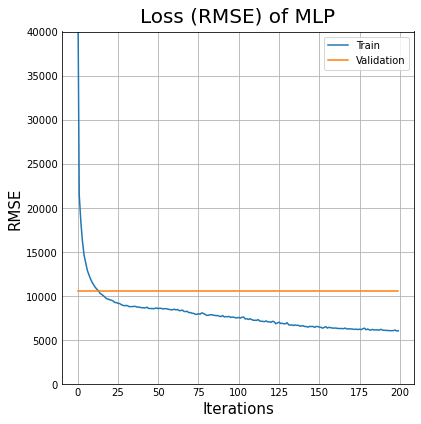

In [597]:
plt.plot(losses, label="Train")
plt.plot(val_loss, label="Validation")
plt.legend()
plt.ylim([0, 40000])
plt.title("Loss (RMSE) of MLP", fontsize=20, pad=10)
plt.xlabel("Iterations", fontsize=15)
plt.ylabel("RMSE", fontsize=15)

In [579]:
mlp = init_mlp()

num_iterations = 200
train_rmse_arr = []
val_rmse_arr = []

x_train, x_val, y_train, y_val = train_test_split(scaled_train_features, train_target, test_size=0.2)
for num_iter in range(num_iterations):
    fitted_mlp = mlp.fit(x_train, y_train)
    
    train_rmse = math.sqrt(fitted_mlp.loss_)
    train_rmse_arr += [train_rmse]
    predictions = fitted_mlp.predict(x_val)
    val_rmse = rmse(predictions, y_val)
    val_rmse_arr += [val_rmse]
    
    print("TRAIN RMSE:", train_rmse)
    print("VAL RMSE:", val_rmse)
    
    joint_arr = np.concatenate([x_train, y_train.reshape(-1, 1)], axis=1)
    np.random.shuffle(joint_arr)
    x_train = joint_arr[:, :115]
    y_train = joint_arr[:, 115]
    
fitted_mlp = mlp.fit(scaled_train_features, train_target)

/Users/alexandrospouroullis/miniforge3/envs/LoopQPrize/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


TRAIN RMSE: 48613.19897543906
VAL RMSE: 33269.564307077155
TRAIN RMSE: 20125.41554691259
VAL RMSE: 21211.45431451228
TRAIN RMSE: 14381.68710463999
VAL RMSE: 17626.710913586823
TRAIN RMSE: 12812.914833269053
VAL RMSE: 16075.915889861733
TRAIN RMSE: 12094.298086010343
VAL RMSE: 16229.00891220304
TRAIN RMSE: 11602.374620299503
VAL RMSE: 14493.084750716667
TRAIN RMSE: 11429.240549283284
VAL RMSE: 14997.391098503284
TRAIN RMSE: 11130.972827423895
VAL RMSE: 14040.88055697216
TRAIN RMSE: 11196.230620680075
VAL RMSE: 14052.457560130226
TRAIN RMSE: 10874.942368097663
VAL RMSE: 13635.40741196527
TRAIN RMSE: 10667.234260977906
VAL RMSE: 13753.231042826408
TRAIN RMSE: 10550.433304996259
VAL RMSE: 13327.587282542545
TRAIN RMSE: 10478.943990015694
VAL RMSE: 13563.15805420733
TRAIN RMSE: 10482.619351950165
VAL RMSE: 13544.56293545806
TRAIN RMSE: 10057.173503966535
VAL RMSE: 12906.323011722607
TRAIN RMSE: 10124.530480091606
VAL RMSE: 14991.527142604096
TRAIN RMSE: 9987.912534813036
VAL RMSE: 12607.250

TRAIN RMSE: 7120.564473248836
VAL RMSE: 9554.018350190672
TRAIN RMSE: 7051.126963971668
VAL RMSE: 9625.628774659717
TRAIN RMSE: 6980.791182824827
VAL RMSE: 9668.385914114602
TRAIN RMSE: 7011.668405800301
VAL RMSE: 9607.548717962169
TRAIN RMSE: 7213.14995304302
VAL RMSE: 9371.824044423574
TRAIN RMSE: 7016.665423383145
VAL RMSE: 9497.419326619793
TRAIN RMSE: 7208.854803236026
VAL RMSE: 9596.307642717617
TRAIN RMSE: 7010.351581034663
VAL RMSE: 9506.546105459696
TRAIN RMSE: 7066.560340062593
VAL RMSE: 9783.381607862353
TRAIN RMSE: 7055.522781177467
VAL RMSE: 9763.09114638571
TRAIN RMSE: 7091.059430517324
VAL RMSE: 11169.63480764249
TRAIN RMSE: 7108.686829684025
VAL RMSE: 9790.87259313979
TRAIN RMSE: 7086.2103541138185
VAL RMSE: 9767.636817100913
TRAIN RMSE: 6941.477859199313
VAL RMSE: 9628.154792373536
TRAIN RMSE: 7000.653978048809
VAL RMSE: 9572.25453257089
TRAIN RMSE: 7064.148393478174
VAL RMSE: 9514.9388221309
TRAIN RMSE: 7141.4536878250265
VAL RMSE: 9720.391130144964
TRAIN RMSE: 6905.4

Text(0, 0.5, 'RMSE')

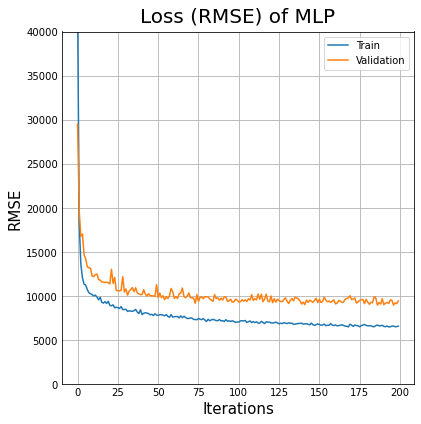

In [570]:
plt.plot(train_rmse_arr, label="Train")
plt.plot(val_rmse_arr, label="Validation")
plt.legend()
plt.ylim([0, 40000])
plt.title("Loss (RMSE) of MLP", fontsize=20, pad=10)
plt.xlabel("Iterations", fontsize=15)
plt.ylabel("RMSE", fontsize=15)

In [494]:
fitted_mlp.validation_scores

AttributeError: 'MLPRegressor' object has no attribute 'validation_scores'